<a href="https://colab.research.google.com/github/norulwahab/nor_python_ml/blob/main/Malaria_cnn_Model_Subclassing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten, InputLayer,BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
dataset, dataset_info=tfds.load('malaria',with_info=True, as_supervised=True,shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteR9MR6J/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
def splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset,val_dataset,test_dataset

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)


##Data Visualization##

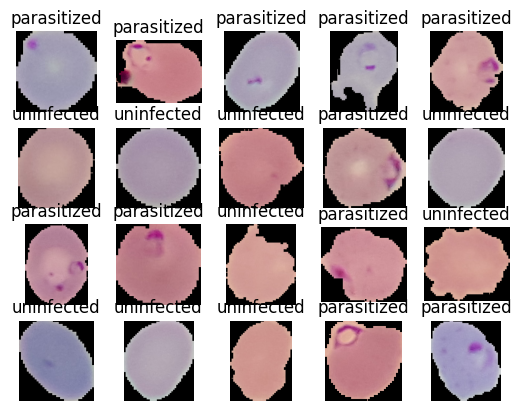

In [5]:
for i, (image, label) in enumerate(train_dataset.take(20)):
  plt.subplot(4,5,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

##Processing##


In [6]:
IMAGE_SIZE=224
def resize_rescale(image,label):
  return tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255.0,label

In [7]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
# for image,label in train_dataset.take(1):
#   print(image,label)

In [7]:
train_dataset=train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [8]:
val_dataset=val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
test_dataset=test_dataset.batch(1)

##Model Creation and Training


##Model Subclassing##

In [10]:
class FeaturesExtractor(Layer):
  def __init__(self,filters, kernel_size, strides, padding, activation, pool_size):
    super(FeaturesExtractor,self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides = strides, padding = padding, activation=activation)
    self.bnorm_1 = BatchNormalization()
    self.pooling_1 = MaxPooling2D(pool_size=pool_size, strides = 2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides = strides, padding = padding, activation=activation)
    self.bnorm_2 = BatchNormalization()
    self.pooling_2 = MaxPooling2D(pool_size=pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self. bnorm_1(x)
    x = self.pooling_1(x)
    x = self.conv_2(x)
    x = self.bnorm_2(x)
    x = self.pooling_2(x)

    return x

#features_sub_class = FeaturesExtractor(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu', pool_size=2)

In [11]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel,self).__init__()
    self.features_extractor = FeaturesExtractor(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu', pool_size=2)
    self.flatten = Flatten()
    self.dense_1= Dense(100, activation = 'relu')
    self.bnorm_1= BatchNormalization()

    self.dense_2= Dense(10, activation = 'relu')
    self.bnorm_2= BatchNormalization()

    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.features_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.bnorm_1(x)
    x = self.dense_2(x)
    x = self.bnorm_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_class = LenetModel()
lenet_sub_class(tf.zeros([1,224,224,3]))
lenet_sub_class.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features_extractor (Featur  multiple                  1488      
 esExtractor)                                                    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  4665700   
                                                                 
 batch_normalization_2 (Bat  multiple                  400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_3 (Bat  multiple                  

##Functional API##

In [12]:
lenet_sub_class.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(),metrics='accuracy')

In [28]:
history= lenet_sub_class.fit(train_dataset,validation_data= val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 50s 63ms/step - loss: 0.3663 - accuracy: 0.8387 - val_loss: 0.5585 - val_accuracy: 0.6998
Epoch 2/20
689/689 [==============================] - 42s 61ms/step - loss: 0.2197 - accuracy: 0.9198 - val_loss: 0.2008 - val_accuracy: 0.9285
Epoch 3/20
689/689 [==============================] - 42s 60ms/step - loss: 0.1698 - accuracy: 0.9400 - val_loss: 0.1674 - val_accuracy: 0.9456
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1425 - accuracy: 0.9480 - val_loss: 0.1752 - val_accuracy: 0.9437
Epoch 5/20
689/689 [==============================] - 54s 79ms/step - loss: 0.1127 - accuracy: 0.9582 - val_loss: 0.1729 - val_accuracy: 0.9437
Epoch 6/20
689/689 [==============================] - 52s 75ms/step - loss: 0.0756 - accuracy: 0.9732 - val_loss: 0.2392 - val_accuracy: 0.9147
Epoch 7/20
689/689 [==============================] - 41s 60ms/step - loss: 0.0483 - accuracy: 0.9841 - val_loss: 0.2158 - val_accuracy:

<ipython-input-29-2e8b6b8ce6d7>:6: UserWarning: The label '_' of 'o' starts with '_'. It is thus excluded from the legend.
  plt.legend('Training_Loss','Validation_Loss')
<ipython-input-29-2e8b6b8ce6d7>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training_Loss','Validation_Loss')


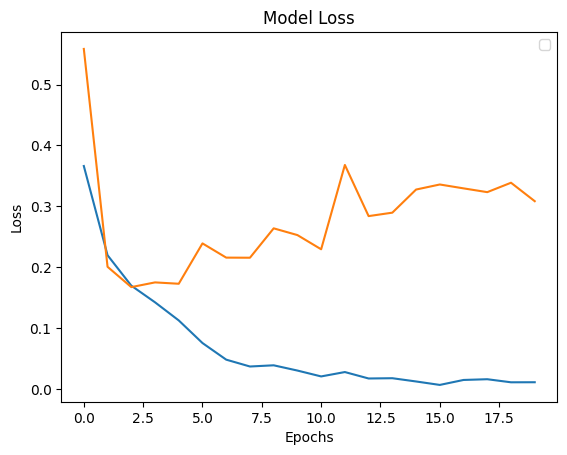

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend('Training_Loss','Validation_Loss')
plt.show()

<ipython-input-30-857611124634>:6: UserWarning: The label '_' of 'c' starts with '_'. It is thus excluded from the legend.
  plt.legend('Training_Accuracy','Validation_Accuracy')
<ipython-input-30-857611124634>:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training_Accuracy','Validation_Accuracy')


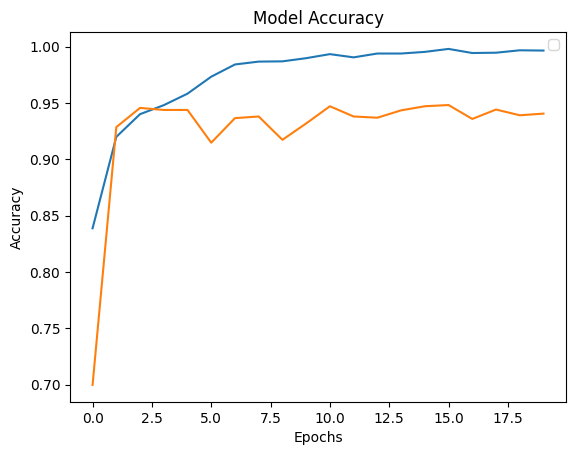

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend('Training_Accuracy','Validation_Accuracy')
plt.show()

In [31]:
lenet_sub_class.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.3298 - accuracy: 0.9329


[0.32984352111816406, 0.9328981041908264]

In [32]:
lenet_sub_class.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.9970482

In [33]:
def infected_or_not(x):
  if(x<0.5):
    return str('I')
  else:
    return str('U')

1/1 [==============================] - 0s 17ms/step


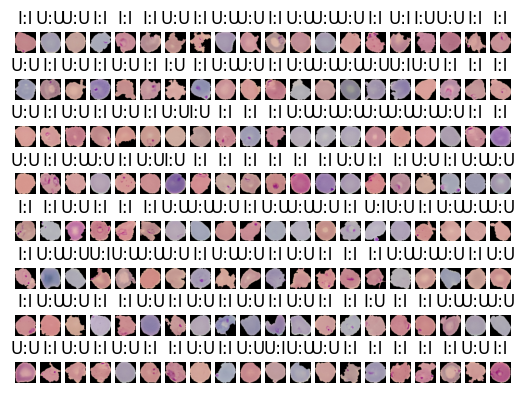

In [34]:
for i,(image,label) in enumerate(test_dataset.take(160)):
  plt.subplot(8,20,i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0])) + ':' +str(infected_or_not(lenet_sub_class.predict(image)[0][0])))
  plt.axis('off')